In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
from src.agents.RAGAgent import embed_text

/home/ubuntu/investigaton-NLP-1/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"Total RAM: {ram_gb:.2f} GB")


Total RAM: 15.42 GB


# RAG

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
def rag_similarity(context, pos_query, neg_query):
    model = 'ollama/nomic-embed-text'
    z_context = embed_text(context, model)
    z_pos_query = embed_text(pos_query, model)
    z_neg_query = embed_text(neg_query, model)

    return np.dot(z_context, z_pos_query), np.dot(z_context, z_neg_query)
    #print(f'RAG similarity: {np.dot(z1_norm, z2_norm)}')

# SAE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
sae_base_model_name = "EleutherAI/pythia-70m-deduped"
sae_release = "ctigges/pythia-70m-deduped__res-sm_processed"
sae_id      = "4-res-sm"
hook_name   = "blocks.4.hook_resid_post"

In [6]:
sae_base_model_name = "gemma-2b-it"
sae_release = "gemma-2b-it-res-jb"
sae_id = "blocks.12.hook_resid_post"
hook_name = "blocks.12.hook_resid_post" 

In [7]:
sae_base_model = HookedTransformer.from_pretrained_no_processing(
    sae_base_model_name,
    device=device,
    dtype=torch.float16,   # float32 is safest on CPU
)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:37<00:00, 18.96s/it]


Loaded pretrained model gemma-2b-it into HookedTransformer


In [8]:
sae, sae_cfg, sparsity = SAE.from_pretrained(
    release=sae_release,
    sae_id=sae_id,
    device=device,
)
sae.eval()

/tmp/ipykernel_4896/1603754695.py:1: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, sae_cfg, sparsity = SAE.from_pretrained(


StandardSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [9]:
def sae_encode_text(
    model, 
    sae, 
    text, 
    hook_name, 
    prepend_bos=True, 
    method="mean",   # "mean", "max", or "topk"
    k=3
):
    with torch.no_grad():
        tokens = model.to_tokens(text, prepend_bos=prepend_bos)
        _, cache = model.run_with_cache(tokens, names_filter=[hook_name])
        acts = cache[hook_name]              # [batch, seq, d_model]
        acts_no_bos = acts[:, 1:, :]         # [batch, seq-1, d_model]
        feature_acts = sae.encode(acts_no_bos)  # [batch, seq-1, n_features]

        # ------- Aggregation methods -------
        if method == "mean":
            z = feature_acts.mean(dim=1)     # [B, F]

        elif method == "max":
            z = feature_acts.max(dim=1).values  # [B, F]

        elif method == "topk":
            seq_len = feature_acts.shape[1]
            k_eff = min(k, seq_len)
            topk_vals, _ = torch.topk(feature_acts, k=k_eff, dim=1)
            z = topk_vals.mean(dim=1)        # [B, F]

        else:
            raise ValueError(f"Unknown method '{method}', choose from 'mean', 'max', 'topk'.")

        # Final vector
        z = z.squeeze(0).cpu().numpy()
        return z / np.linalg.norm(z)

In [10]:
def tanimoto_similarity(z1, z2):
    dot = np.dot(z1, z2)
    denom = np.dot(z1, z1) + np.dot(z2, z2) - dot
    return dot / denom if denom != 0 else 0.0

def jaccard_similarity(z1, z2):
    f1 = set(np.nonzero(z1)[0])
    f2 = set(np.nonzero(z2)[0])
    return len(f1 & f2) / len(f1 | f2)

def sae_similarity(context, pos_query, neg_query, method="topk", k=3):
    z_context = sae_encode_text(sae_base_model, sae, context, hook_name, method=method, k=k)
    z_pos_query = sae_encode_text(sae_base_model, sae, pos_query, hook_name, method=method, k=k)
    z_neg_query = sae_encode_text(sae_base_model, sae, neg_query, hook_name, method=method, k=k)
    return np.dot(z_context, z_pos_query), np.dot(z_context, z_neg_query)
    #return tanimoto_similarity(z_context, z_pos_query), tanimoto_similarity(z_context, z_neg_query)
    #return jaccard_similarity(z_context, z_pos_query), jaccard_similarity(z_context, z_neg_query)


# SAE vs RAG

In [11]:
def compare(context, pos_query, neg_query):
    return rag_similarity(context, pos_query, neg_query), sae_similarity(context, pos_query, neg_query)

In [12]:
examples_1 = [
    {
        "context": (
            "User: Which one would you say is the best for a romantic dinner?\n"
            "Assistant: I would recommend Roscioli. It has a cozy and intimate atmosphere "
            "with soft lighting and excellent service."
        ),
        "pos_query": "Can you remind me of the romantic restaurant in Rome you recommended for dinner?",
        "neg_query": "Can you remind me which museum in Rome you said had the best collection of ancient sculptures?",
    },
    {
        "context": (
            "User: I want a compact camera for street photography, something small but with great image quality. "
            "Any suggestions?\n"
            "Assistant: You might really like the Ricoh GR III. It’s very pocketable and has an excellent "
            "28mm-equivalent lens that’s great for street shots."
        ),
        "pos_query": "What was the small street photography camera you suggested, the one with the 28mm lens?",
        "neg_query": "What was the tripod you recommended for long-exposure night photography?",
    },
    {
        "context": (
            "User: My API is slowing down under load. Could it be the Docker configuration?\n"
            "Assistant: It’s possible. I’d start by checking the CPU and memory limits on the container "
            "and see if you’re hitting them during peak traffic."
        ),
        "pos_query": "What did you say I should look at in my Docker setup to understand why the API slows down?",
        "neg_query": "What did you say I should look at in my Postgres configuration to reduce slow queries?",
    },
    {
        "context": (
            "User: I’m trying to choose between airlines for a long-haul flight to Tokyo. Any preference?\n"
            "Assistant: If you can, go with ANA. Their economy seats are more comfortable and the service "
            "is consistently excellent."
        ),
        "pos_query": "Which airline did you say was better for my long flight to Tokyo?",
        "neg_query": "Which website did you say was best for finding cheap hotel deals in Tokyo?",
    },
    {
        "context": (
            "User: I have an exam in statistical mechanics next month and I’m overwhelmed. "
            "How should I structure my study time?\n"
            "Assistant: Focus first on the partition function and the main ensembles. Then spend time on typical "
            "problems with phase transitions and critical exponents, and leave the more exotic topics for last."
        ),
        "pos_query": "What did you tell me to prioritize when studying for my statistical mechanics exam?",
        "neg_query": "What did you tell me to prioritize when preparing my job interview presentation?",
    },
    {
        "context": (
            "User: I need a laptop for machine learning experiments. Any particular specs I should aim for?\n"
            "Assistant: Try to get at least 32 GB of RAM and an NVIDIA GPU with at least 8 GB of VRAM. "
            "That will make training small to medium models much smoother."
        ),
        "pos_query": "Can you remind me what specs you recommended for a laptop to run my ML experiments?",
        "neg_query": "Can you remind me what specs you recommended for a monitor for photo editing?",
    },
    {
        "context": (
            "User: I’m visiting Barcelona for a few days and want a nice day hike nearby. Any suggestions?\n"
            "Assistant: You could hike in Montserrat. It’s about an hour from the city by train and has beautiful "
            "mountain views and well-marked trails."
        ),
        "pos_query": "What was the hiking spot near Barcelona you mentioned that I can reach by train?",
        "neg_query": "What was the beach town near Barcelona you mentioned that’s good for a day of swimming?",
    },
    {
        "context": (
            "User: I want a sci-fi novel that’s thoughtful but still fun to read. Any ideas?\n"
            "Assistant: You might enjoy \"The Three-Body Problem.\" It mixes hard science with a very engaging story."
        ),
        "pos_query": "Which sci-fi book did you recommend that combines hard science with an engaging story?",
        "neg_query": "Which non-fiction book did you recommend for learning basic investing principles?",
    },

    {
        "context": (
            "User: I'm finally replacing my old laptop. Do you think 16GB of RAM is enough for light coding?\n"
            "Assistant: For light coding it's fine, but if you plan to do ML experiments or heavy multitasking, "
            "I'd recommend going for 32GB instead."
        ),
        "pos_query": "What was the RAM amount you recommended for heavier ML coding workloads?",
        "neg_query": "What was the phone model you said had the best battery life for traveling?"
    },
    {
        "context": (
            "User: I'm planning a trip to Florence. Is there a museum I absolutely shouldn't miss?\n"
            "Assistant: Definitely visit the Uffizi Gallery. It's one of the most important art museums in the world."
        ),
        "pos_query": "What was the museum in Florence you told me I shouldn't miss?",
        "neg_query": "Which restaurant in Florence did you say had the best bistecca alla fiorentina?"
    },

    {
        "context": (
            "User: I'm choosing a film camera for trying analog photography. Any recommendation?\n"
            "Assistant: The Nikon FE is a great starting point. Reliable, sturdy, and easy to use."
        ),
        "pos_query": "Which beginner film camera did you recommend to me?",
        "neg_query": "What digital camera did you say was best for recording 4K video?"
    },

    {
        "context": (
            "User: My sourdough bread keeps coming out too dense. What should I fix?\n"
            "Assistant: Try increasing the hydration slightly and give the dough a longer bulk fermentation."
        ),
        "pos_query": "What did you say I should adjust in my sourdough recipe to avoid dense loaves?",
        "neg_query": "What did you say I should adjust in my lasagna recipe to make the sauce thicker?"
    },

    {
        "context": (
            "User: I'm thinking of learning a second programming language after Python. Suggestions?\n"
            "Assistant: Go with Rust. It forces good habits and teaches you a lot about memory safety and performance."
        ),
        "pos_query": "Which programming language did you recommend I learn after Python?",
        "neg_query": "Which photo editing software did you recommend for color grading RAW images?"
    },

    {
        "context": (
            "User: I want something philosophical but easy to read. Any book recommendations?\n"
            "Assistant: You might like 'The Stranger' by Albert Camus. It's short but very thought-provoking."
        ),
        "pos_query": "Which philosophical novel did you recommend that was short and thought-provoking?",
        "neg_query": "Which fantasy novel did you recommend that had dragons and magic?"
    },

    {
        "context": (
            "User: I'm trying intermittent fasting for the first time. Any tips for beginners?\n"
            "Assistant: Start with a 14:10 schedule and gradually increase the fasting window if you feel comfortable."
        ),
        "pos_query": "What fasting schedule did you say was good for beginners?",
        "neg_query": "What running schedule did you say was good for preparing a marathon?"
    },

    {
        "context": (
            "User: My code is running much slower after I moved to Windows from Linux. Any ideas?\n"
            "Assistant: Check whether Windows Defender is scanning your Python files. That often slows down execution."
        ),
        "pos_query": "What did you say might be slowing down my Python code on Windows?",
        "neg_query": "What did you say might be causing my internet to disconnect randomly?"
    },

    {
        "context": (
            "User: I'm decorating my apartment and want a minimalist look. Any advice?\n"
            "Assistant: Stick to neutral colors and reduce visible clutter. Furniture with clean lines works best."
        ),
        "pos_query": "What kind of design recommendations did you give me for a minimalist apartment?",
        "neg_query": "What kind of exercise recommendations did you give me for building muscle?"
    },

    {
        "context": (
            "User: I'm learning guitar but my fingers hurt a lot. Is that normal?\n"
            "Assistant: Yes, totally normal. You'll develop calluses after a few weeks and the pain will decrease."
        ),
        "pos_query": "What did you say would eventually stop hurting when practicing guitar?",
        "neg_query": "What did you say would eventually improve if I keep practicing my coding skills?"
    },
    {
        "context": (
            "User: I'm trying to pick a gift for someone who loves astronomy. Any ideas?\n"
            "Assistant: A high-quality star map poster or a beginner telescope would make a great astronomy gift."
        ),
        "pos_query": "What astronomy-themed gift did you say would be a good idea?",
        "neg_query": "What cooking tool did you recommend for making homemade pasta?"
    },
    {
        "context": (
            "User: My neck hurts after long coding sessions. What should I adjust?\n"
            "Assistant: Try raising your monitor to eye level and consider using an ergonomic chair."
        ),
        "pos_query": "What posture adjustment did you say would help with my neck pain while coding?",
        "neg_query": "What adjustment did you say would help keep my sourdough starter active?"
    },
    {
        "context": (
            "User: I need something lightweight to read on the plane. Any book that's easy to get into?\n"
            "Assistant: 'The Alchemist' is a great choice—short, inspiring, and very readable."
        ),
        "pos_query": "Which easy-to-read book did you recommend for my flight?",
        "neg_query": "Which technical manual did you recommend for learning Kubernetes?"
    },
    {
        "context": (
            "User: I'm considering adopting a dog. Anything I should plan for in advance?\n"
            "Assistant: Make sure you have time for daily walks and a consistent routine—they really need structure."
        ),
        "pos_query": "What did you tell me dogs need in terms of routine?",
        "neg_query": "What did you tell me SQL databases need in terms of indexing?"
    },
    {
        "context": (
            "User: I'm struggling to stay awake while studying. Any tips?\n"
            "Assistant: Try the Pomodoro technique and avoid studying lying down—it makes a big difference."
        ),
        "pos_query": "What study strategy did you say could help me stay alert?",
        "neg_query": "What financial strategy did you say could help me save for retirement?"
    },
    {
        "context": (
            "User: I'm going to Iceland in winter. What should I absolutely pack?\n"
            "Assistant: Thermal layers and waterproof boots are must-haves for that season."
        ),
        "pos_query": "What essential items did you tell me to pack for Iceland?",
        "neg_query": "What essential items did you tell me to buy for setting up a home gym?"
    },
    {
        "context": (
            "User: I'm doing my first 10k race. Any advice on pacing?\n"
            "Assistant: Start slower than you think and gradually increase your pace after the halfway point."
        ),
        "pos_query": "How did you say I should pace myself for the 10k?",
        "neg_query": "How did you say I should pace myself when learning jazz piano?"
    },
    {
        "context": (
            "User: My houseplants keep dying. What am I doing wrong?\n"
            "Assistant: You're likely overwatering. Most indoor plants prefer to dry out between waterings."
        ),
        "pos_query": "What plant care mistake did you say I was probably making?",
        "neg_query": "What mistake did you say I was making in my SQL queries?"
    },
    {
        "context": (
            "User: I'm upgrading my bike and want to go faster. What should I change first?\n"
            "Assistant: Swapping to lighter tires usually makes a noticeable difference."
        ),
        "pos_query": "What upgrade did you say would help my bike go faster?",
        "neg_query": "What upgrade did you say would help my computer run Photoshop?"
    },
    {
        "context": (
            "User: My meditation practice feels unfocused lately. Any suggestions?\n"
            "Assistant: Try guided audio sessions—they help bring structure when your mind wanders easily."
        ),
        "pos_query": "What did you suggest to help me stay focused during meditation?",
        "neg_query": "What did you suggest to help me clean hard water stains?"
    },
    {
        "context": (
            "User: I want to start eating healthier but don’t know where to begin.\n"
            "Assistant: Start by adding more vegetables to each meal and cutting back on sugary drinks."
        ),
        "pos_query": "What first step did you recommend for eating healthier?",
        "neg_query": "What first step did you recommend for learning Java?"
    },
    {
        "context": (
            "User: My backpacking tent feels cramped. Should I get a bigger one?\n"
            "Assistant: Yes—going one person size above your actual group usually feels much more comfortable."
        ),
        "pos_query": "What tent sizing advice did you give me for backpacking?",
        "neg_query": "What sizing advice did you give me for choosing a winter coat?"
    },
    {
        "context": (
            "User: I'm losing motivation to exercise. Any trick to keep going?\n"
            "Assistant: Setting very small daily goals works well—even just 10 minutes counts."
        ),
        "pos_query": "What was the motivational trick you suggested for exercise?",
        "neg_query": "What motivational trick did you suggest for writing my thesis?"
    },
    {
        "context": (
            "User: I think my espresso tastes sour. What should I adjust?\n"
            "Assistant: Try grinding a bit finer and increasing the extraction time."
        ),
        "pos_query": "How did you say I could fix sour espresso?",
        "neg_query": "How did you say I could fix a leaky faucet?"
    },
    {
        "context": (
            "User: I'm redoing my desk setup and want it to be more ergonomic.\n"
            "Assistant: Keep your wrists neutral and make sure your elbows rest at a 90-degree angle."
        ),
        "pos_query": "What ergonomic tips did you give me for my desk setup?",
        "neg_query": "What ergonomic tips did you give me for improving my running stride?"
    },
    {
        "context": (
            "User: I'm choosing a gift for someone who loves cooking.\n"
            "Assistant: A high-quality chef’s knife is always appreciated and lasts for years."
        ),
        "pos_query": "Which cooking-related gift did you recommend?",
        "neg_query": "Which travel-related gift did you recommend for someone visiting Patagonia?"
    },
    {
        "context": (
            "User: I'm having trouble sleeping lately. Any ideas?\n"
            "Assistant: Try keeping your room cooler and reducing screen time before bed."
        ),
        "pos_query": "What did you say I should adjust to improve my sleep?",
        "neg_query": "What did you say I should adjust to improve my coding performance?"
    },
    {
        "context": (
            "User: My cat keeps scratching the couch. What should I do?\n"
            "Assistant: Provide a scratching post and reward them when they use it."
        ),
        "pos_query": "What solution did you suggest for my cat scratching the couch?",
        "neg_query": "What solution did you suggest for fixing my slow WiFi?"
    },
    {
        "context": (
            "User: I'm getting into baking and want an easy recipe to start.\n"
            "Assistant: Banana bread is perfect for beginners—very forgiving and delicious."
        ),
        "pos_query": "What beginner-friendly baking recipe did you recommend?",
        "neg_query": "What high-protein meal did you recommend for post-workout recovery?"
    },
    {
        "context": (
            "User: I'm worried my resume looks too empty. Any improvements?\n"
            "Assistant: Add a small projects section—anything you’ve built, even personal experiments, helps a lot."
        ),
        "pos_query": "What improvement did you suggest to make my resume look stronger?",
        "neg_query": "What improvement did you suggest to make my standing desk more stable?"
    },
    {
        "context": (
            "User: I'm debating whether to learn piano or guitar first.\n"
            "Assistant: I'd start with guitar—it's more intuitive for beginners and you’ll see progress quickly."
        ),
        "pos_query": "Which instrument did you say I should learn first?",
        "neg_query": "Which instrument did you say I should avoid learning first because it's too intuitive?",
    },
    {
        "context": (
            "User: I'm choosing a tablet mainly for reading scientific papers.\n"
            "Assistant: Go with the iPad Air—the screen size is perfect and the battery life is excellent."
        ),
        "pos_query": "Which tablet did you recommend for reading papers?",
        "neg_query": "Which papers did you recommend I read on the tablet?",
    },
    {
        "context": (
            "User: I'm trying to cut down on caffeine. Any replacement for morning coffee?\n"
            "Assistant: Try green tea—it has less caffeine but still gives a gentle boost."
        ),
        "pos_query": "What drink did you suggest as a lighter caffeine alternative?",
        "neg_query": "What caffeine alternative did you suggest avoiding in the morning?",
    },
    {
        "context": (
            "User: I'm rebuilding my PC and need a good CPU for programming.\n"
            "Assistant: The Ryzen 7 series is a great option—excellent multithreaded performance."
        ),
        "pos_query": "Which CPU did you say is a good option for programming?",
        "neg_query": "Which programming option did you say is good for the CPU?",
    },
    {
        "context": (
            "User: My sleep schedule is completely off. Any starting point?\n"
            "Assistant: Try going to bed at the same time each night and avoid screens one hour before."
        ),
        "pos_query": "What did you say I should do before bed to fix my sleep schedule?",
        "neg_query": "What did you say would happen if I fixed my sleep schedule before going to bed?",
    },
    {
        "context": (
            "User: I'm new to resistance training. What weight should I begin with?\n"
            "Assistant: Start with something light enough to keep good form—usually 2–5 kg."
        ),
        "pos_query": "What starting weight did you recommend for resistance training?",
        "neg_query": "What resistance did you suggest for training starting weights?",
    },
    {
        "context": (
            "User: I'm overwhelmed choosing a budget microphone.\n"
            "Assistant: The Audio-Technica ATR2100x is fantastic for the price and very beginner-friendly."
        ),
        "pos_query": "Which budget microphone did you recommend?",
        "neg_query": "Which budget did you recommend for choosing a microphone?",
    },
    {
        "context": (
            "User: I'm doing my first half marathon and unsure about shoes.\n"
            "Assistant: Get something with good cushioning—Nike Pegasus is a safe choice for beginners."
        ),
        "pos_query": "Which running shoe did you say is good for a beginner?",
        "neg_query": "Which beginner did you say is good for running shoes?",
    },
    {
        "context": (
            "User: I'm planning a weekend trip and want something relaxing.\n"
            "Assistant: A small cabin near the lake is perfect—quiet, peaceful, and not far from the city."
        ),
        "pos_query": "What relaxing weekend option did you recommend?",
        "neg_query": "What weekend did you recommend relaxing rather than taking a trip?",
    },
    {
        "context": (
            "User: I'm learning to cook and want something simple.\n"
            "Assistant: Start with pasta aglio e olio—few ingredients and hard to mess up."
        ),
        "pos_query": "Which simple dish did you suggest I start cooking?",
        "neg_query": "Which cooking did you suggest I start with because it's too simple?",
    },
    {
        "context": (
            "User: I'm trying intermittent fasting but don't know where to begin.\n"
            "Assistant: Begin with a 14:10 schedule and see how your body responds."
        ),
        "pos_query": "What fasting schedule did you say I should begin with?",
        "neg_query": "What schedule did you say should begin fasting after I eat?",
    },
    {
        "context": (
            "User: I'm having trouble staying focused at work.\n"
            "Assistant: Try working in 25-minute blocks with short breaks—Pomodoro is very effective."
        ),
        "pos_query": "What technique did you recommend to help me focus?",
        "neg_query": "What focus did you recommend to help me learn the Pomodoro technique?",
    }
]

Los siguientes son examples con dos preguntas: una que se responde con el contexto y la otra super lejos semánticamente.

In [13]:
examples_2 = [
    {
        "context": (
            "User: Could you explain why some telescopes use a curved secondary mirror?\n"
            "Assistant: Certainly! A curved secondary helps correct optical aberrations and can "
            "redirect light into a more compact focal plane design."
        ),
        "pos_query": "What does the curved secondary mirror help correct?",
        "neg_query": "How many novels did Charles Dickens publish in his lifetime?"
    },
    {
        "context": (
            "User: How do I prevent numerical instability in my finite-difference simulation?\n"
            "Assistant: You can reduce instability by decreasing the time step and ensuring the "
            "Courant condition is satisfied."
        ),
        "pos_query": "Which condition must be satisfied to reduce instability?",
        "neg_query": "Where do hummingbirds migrate during the winter season?"
    },
    {
        "context": (
            "User: Why do neural networks sometimes fail to generalize well?\n"
            "Assistant: Often it's due to overfitting, where the model memorizes training data "
            "instead of learning underlying patterns."
        ),
        "pos_query": "What is the phenomenon called when the model memorizes training data?",
        "neg_query": "What materials were used to build Viking longships?"
    },
    {
        "context": (
            "User: What does the event horizon represent in a black hole?\n"
            "Assistant: It marks the boundary beyond which no information or light can escape "
            "the gravitational pull."
        ),
        "pos_query": "What cannot escape past the event horizon?",
        "neg_query": "Which planet has the shortest day in our solar system?"
    },
    {
        "context": (
            "User: How can I speed up convergence in gradient descent?\n"
            "Assistant: Using momentum or adaptive learning rate methods like Adam can help "
            "accelerate convergence."
        ),
        "pos_query": "Which optimizer uses adaptive learning rates?",
        "neg_query": "When did the first Olympic marathon take place?"
    },
    {
        "context": (
            "User: What determines the luminosity of a main-sequence star?\n"
            "Assistant: Its mass is the key factor, as it dictates the rate of nuclear fusion "
            "in the core."
        ),
        "pos_query": "What property mainly determines a main-sequence star’s luminosity?",
        "neg_query": "How does a chef make traditional miso paste at home?"
    },
    {
        "context": (
            "User: Why is normalization important for training deep networks?\n"
            "Assistant: Normalization keeps input scales consistent, which stabilizes gradients "
            "and speeds up training."
        ),
        "pos_query": "How does normalization affect gradient behavior?",
        "neg_query": "What year was aluminum first commercially produced?"
    },
    {
        "context": (
            "User: How does the Doppler effect influence radial velocity measurements?\n"
            "Assistant: It causes spectral lines to shift depending on whether the star moves "
            "toward or away from the observer."
        ),
        "pos_query": "What happens to spectral lines when a star moves toward us?",
        "neg_query": "Which species of cactus grows the tallest in the Sahara Desert?"
    },
    {
        "context": (
            "User: What's the purpose of dropout in neural network training?\n"
            "Assistant: Dropout reduces overfitting by randomly deactivating neurons during "
            "training."
        ),
        "pos_query": "How does dropout help prevent overfitting?",
        "neg_query": "Which dynasty built most of the major pyramids in ancient Egypt?"
    },
    {
        "context": (
            "User: Why do astronomers prefer CCDs over photographic plates?\n"
            "Assistant: CCDs offer higher sensitivity and better linearity, enabling more "
            "precise measurements."
        ),
        "pos_query": "What advantage do CCDs provide to improve measurement precision?",
        "neg_query": "What type of soil produces the spiciest varieties of chili peppers?"
    },
    {
        "context": (
            "User: What is the function of the transformer architecture’s attention mechanism?\n"
            "Assistant: It allows the model to weight different parts of the input sequence "
            "based on relevance."
        ),
        "pos_query": "What does the attention mechanism assign to different parts of a sequence?",
        "neg_query": "Which European country consumes the most mineral water per capita?"
    },
    {
        "context": (
            "User: How do tidal forces affect moons orbiting giant planets?\n"
            "Assistant: Tidal forces can induce heating, drive geological activity, and even "
            "maintain orbital resonance."
        ),
        "pos_query": "What can tidal heating generate on a moon?",
        "neg_query": "What fabrics are most durable for making outdoor hammocks?"
    },
    {
        "context": (
            "User: Why is regularization useful in linear regression?\n"
            "Assistant: It penalizes large coefficients, reducing variance and improving "
            "generalization."
        ),
        "pos_query": "How does regularization affect large coefficients?",
        "neg_query": "When were the first electric trams introduced in South America?"
    },
    {
        "context": (
            "User: What limits the resolution of a radio interferometer?\n"
            "Assistant: The maximum baseline—the distance between antennas—sets the resolving "
            "power."
        ),
        "pos_query": "What parameter of an interferometer determines its resolving power?",
        "neg_query": "Which ingredients are essential for a traditional Greek spanakopita?"
    },
    {
        "context": (
            "User: What causes aliasing in digital signal processing?\n"
            "Assistant: Undersampling a signal below the Nyquist rate leads to overlapping "
            "frequency components."
        ),
        "pos_query": "What happens if you sample below the Nyquist rate?",
        "neg_query": "How are aristocratic titles inherited in medieval England?"
    },
    {
        "context": (
            "User: Why do we use convolutional layers for image data?\n"
            "Assistant: They exploit spatial locality by applying filters across local patches."
        ),
        "pos_query": "What spatial property do convolutions exploit?",
        "neg_query": "What is the main fermentation agent in kombucha?"
    },
    {
        "context": (
            "User: How does redshift relate to cosmic expansion?\n"
            "Assistant: As space expands, wavelengths stretch, causing galaxies to appear "
            "redshifted."
        ),
        "pos_query": "Why do wavelengths stretch during cosmic expansion?",
        "neg_query": "How did Renaissance painters create ultramarine pigment?"
    },
    {
        "context": (
            "User: What's the benefit of batch normalization?\n"
            "Assistant: It reduces internal covariate shift and stabilizes learning dynamics."
        ),
        "pos_query": "What shift does batch normalization help reduce?",
        "neg_query": "What animals are most commonly featured in Inuit stone carvings?"
    },
    {
        "context": (
            "User: Why do gas giants emit more heat than they receive from the Sun?\n"
            "Assistant: They release energy from slow gravitational contraction, known as "
            "Kelvin–Helmholtz heating."
        ),
        "pos_query": "What type of contraction generates extra heat on gas giants?",
        "neg_query": "Which country produces the largest amount of organic saffron?"
    },
    {
        "context": (
            "User: How does quantization affect neural network inference?\n"
            "Assistant: It reduces precision of weights and activations, speeding up computation "
            "but possibly reducing accuracy."
        ),
        "pos_query": "What aspect of model parameters does quantization reduce?",
        "neg_query": "How do artisans craft traditional Venezuelan cuatro instruments?"
    },
    {
        "context": (
            "User: What drives convection in stellar interiors?\n"
            "Assistant: Temperature gradients create buoyant forces that move plasma upward."
        ),
        "pos_query": "What creates the buoyant forces inside stars?",
        "neg_query": "Which ocean is home to the deepest hydrothermal vents?"
    },
    {
        "context": (
            "User: Why is ensemble learning often more robust?\n"
            "Assistant: Combining multiple models averages out errors and reduces variance."
        ),
        "pos_query": "How does combining models affect variance?",
        "neg_query": "What spices are traditionally used in Ethiopian berbere?"
    },
    {
        "context": (
            "User: How do adaptive optics systems improve astronomical imaging?\n"
            "Assistant: They dynamically adjust mirror shapes to compensate for atmospheric "
            "distortion."
        ),
        "pos_query": "What do adaptive optics systems correct in real time?",
        "neg_query": "What materials are commonly used to build suspension bridges?"
    },
    {
        "context": (
            "User: What is the purpose of a learning rate scheduler?\n"
            "Assistant: It adjusts the learning rate over time to improve training stability and "
            "convergence."
        ),
        "pos_query": "What is being adjusted during training?",
        "neg_query": "Which birds have the longest recorded wingspan?"
    },
    {
        "context": (
            "User: Why do spiral galaxies have distinct arms?\n"
            "Assistant: Density waves compress gas and stars, creating the patterned arms."
        ),
        "pos_query": "What produces the compression that forms spiral arms?",
        "neg_query": "What ingredients are required to make traditional French nougat?"
    },
    {
        "context": (
            "User: How does L2 regularization influence weight updates?\n"
            "Assistant: It adds a penalty proportional to weight magnitude, encouraging smaller "
            "values."
        ),
        "pos_query": "What type of penalty does L2 regularization impose?",
        "neg_query": "How are ceremonial masks carved in Papua New Guinea?"
    },
    {
        "context": (
            "User: What determines a star’s main-sequence lifetime?\n"
            "Assistant: Its mass controls the rate of hydrogen fusion, setting its total lifespan."
        ),
        "pos_query": "Which factor sets the hydrogen fusion rate?",
        "neg_query": "Which mountain range forms the natural border of northern Thailand?"
    },
    {
        "context": (
            "User: Why do we use the softmax function in classification networks?\n"
            "Assistant: It converts logits into a normalized probability distribution."
        ),
        "pos_query": "What does softmax transform logits into?",
        "neg_query": "What methods are used to age traditional cheddar cheese?"
    },
    {
        "context": (
            "User: How do astronomers estimate the mass of exoplanets in RV data?\n"
            "Assistant: They analyze periodic Doppler shifts, which reveal the planet’s minimum "
            "mass."
        ),
        "pos_query": "What aspect of the star's spectrum indicates the planet’s mass?",
        "neg_query": "What ancient techniques were used to create Japanese lacquerware?"
    },
    {
        "context": (
            "User: What is the purpose of a skip connection in deep networks?\n"
            "Assistant: It allows gradients to flow more easily, reducing vanishing issues."
        ),
        "pos_query": "How do skip connections affect gradient flow?",
        "neg_query": "Which flowers bloom earliest during Scandinavian spring?"
    },
    {
        "context": (
            "User: Why is the CMB considered strong evidence for the Big Bang?\n"
            "Assistant: Because it represents relic radiation from an early, hot, dense universe."
        ),
        "pos_query": "What does the CMB originate from?",
        "neg_query": "Which musical scale is most used in Andean folk music?"
    },
    {
        "context": (
            "User: How does label smoothing improve model generalization?\n"
            "Assistant: It prevents the model from becoming overly confident in a single class."
        ),
        "pos_query": "What behavior does label smoothing discourage?",
        "neg_query": "What is the traditional method for preserving Italian anchovies?"
    },
    {
        "context": (
            "User: What defines the Schwarzschild radius?\n"
            "Assistant: It's the radius at which escape velocity equals the speed of light."
        ),
        "pos_query": "At what radius does escape velocity reach light speed?",
        "neg_query": "Which gemstones were prized in ancient Mesopotamian jewelry?"
    },
    {
        "context": (
            "User: Why do recurrent networks suffer from vanishing gradients?\n"
            "Assistant: Repeated multiplication through time causes gradients to shrink "
            "exponentially."
        ),
        "pos_query": "What causes gradients to shrink in recurrent networks?",
        "neg_query": "Where are the oldest surviving Roman mosaics located?"
    },
    {
        "context": (
            "User: How is the age of star clusters estimated?\n"
            "Assistant: Astronomers fit isochrones to the cluster’s color–magnitude diagram."
        ),
        "pos_query": "What diagram is essential for determining cluster ages?",
        "neg_query": "What grains are most common in traditional Moroccan couscous?"
    },
    {
        "context": (
            "User: Why do GANs sometimes fail to converge?\n"
            "Assistant: Because the generator and discriminator can fall into unstable "
            "optimization dynamics."
        ),
        "pos_query": "What two components interact during GAN training?",
        "neg_query": "Which trees produce the lightest natural wood used in furniture making?"
    },
    {
        "context": (
            "User: What is the main driver of plate tectonics?\n"
            "Assistant: Heat from Earth’s interior causes mantle convection, which moves plates."
        ),
        "pos_query": "What drives the motion of tectonic plates?",
        "neg_query": "What fabric is used to make high-quality men’s bow ties?"
    },
    {
        "context": (
            "User: How do astronomers estimate distances to nearby stars?\n"
            "Assistant: They use parallax, measuring the apparent shift of a star over Earth’s orbit."
        ),
        "pos_query": "What method measures the apparent shift of a star?",
        "neg_query": "Which minerals give volcanic glass its characteristic sheen?"
    },
    {
        "context": (
            "User: Why are residual networks easier to train?\n"
            "Assistant: Their architecture preserves information across layers, minimizing gradient "
            "degradation."
        ),
        "pos_query": "What does the architecture of residual networks preserve?",
        "neg_query": "Where were the earliest bronze tools discovered?"
    },
    {
        "context": (
            "User: How does beamforming enhance radio telescope sensitivity?\n"
            "Assistant: It coherently combines signals from multiple antennas to amplify desired "
            "directions."
        ),
        "pos_query": "What does beamforming combine coherently?",
        "neg_query": "Which crops dominate agriculture in northern Vietnam?"
    },
    {
        "context": (
            "User: Why is early stopping used in machine learning?\n"
            "Assistant: It halts training when validation performance stops improving, preventing "
            "overfitting."
        ),
        "pos_query": "When does early stopping interrupt training?",
        "neg_query": "Which festivals are most important in Nepalese Buddhist culture?"
    },
    {
        "context": (
            "User: What causes sunspots to form on the solar surface?\n"
            "Assistant: They arise from strong magnetic fields that inhibit convection locally."
        ),
        "pos_query": "What inhibits convection to create sunspots?",
        "neg_query": "What materials are used to make traditional Persian rugs?"
    },
    {
        "context": (
            "User: How is the Hubble constant measured today?\n"
            "Assistant: Using distance ladders like Cepheids, supernovae, or gravitational lensing."
        ),
        "pos_query": "Which astronomical objects are part of the distance ladder?",
        "neg_query": "When was the first mechanical wristwatch invented?"
    },
    {
        "context": (
            "User: Why is temperature important for semiconductor behavior?\n"
            "Assistant: Carrier mobility and band gap both depend strongly on temperature."
        ),
        "pos_query": "What temperature-dependent property affects carrier mobility?",
        "neg_query": "Which spices are used in Hungarian goulash?"
    },
    {
        "context": (
            "User: What defines a parsec in astronomy?\n"
            "Assistant: It’s the distance at which one AU subtends one arcsecond."
        ),
        "pos_query": "What angle defines a parsec?",
        "neg_query": "How did artisans produce dye from crushed cochineal insects?"
    },
    {
        "context": (
            "User: How do PCA components capture data variance?\n"
            "Assistant: They align with directions that maximize variance in the dataset."
        ),
        "pos_query": "What do PCA directions maximize?",
        "neg_query": "What costumes are traditional during Spain’s Fallas festival?"
    },
    {
        "context": (
            "User: What leads to limb darkening in stellar photospheres?\n"
            "Assistant: Light from the edges comes from shallower, cooler layers, making them "
            "appear dimmer."
        ),
        "pos_query": "Why do stellar edges appear cooler?",
        "neg_query": "Which herbs are essential in Thai green curry paste?"
    },
    {
        "context": (
            "User: Why do LSTMs mitigate vanishing gradients?\n"
            "Assistant: Their gating mechanisms preserve information over long sequences."
        ),
        "pos_query": "What do the gates in LSTMs help preserve?",
        "neg_query": "Which cities led the Hanseatic League in medieval trade?"
    },
    {
        "context": (
            "User: How is gravitational lensing detected?\n"
            "Assistant: By observing distortions in background galaxies caused by massive objects."
        ),
        "pos_query": "What gets distorted due to gravitational lensing?",
        "neg_query": "What type of clay is preferred for traditional Japanese tea bowls?"
    },
    {
        "context": (
            "User: What role do neutrinos play in core-collapse supernovae?\n"
            "Assistant: They transport vast amounts of energy and help revive the shock wave."
        ),
        "pos_query": "What do neutrinos help revive in supernovae?",
        "neg_query": "Which instruments dominate the sound of Argentine chamamé?"
    },
    {
        "context": (
            "User: Why is learning rate crucial for training stability?\n"
            "Assistant: Too large a rate causes divergence, while too small slows learning "
            "dramatically."
        ),
        "pos_query": "What happens if the learning rate is too large?",
        "neg_query": "How did artisans craft mirrors in ancient Mesoamerica?"
    },
    {
        "context": (
            "User: How do astronomers infer stellar composition?\n"
            "Assistant: They analyze absorption lines in the star’s spectrum, which correspond "
            "to specific elements."
        ),
        "pos_query": "What features of the spectrum reveal elements?",
        "neg_query": "What leatherworking techniques are common in Mongolian saddles?"
    }
]


In [14]:
examples = examples_1 + examples_2

In [15]:
print(len(examples))

102


In [16]:
def test_method(backend, method=None, k=None):
    """
    backend: "rag" or "sae"
    method, k: passed through to sae_similarity when backend == "sae"
    """
    related = []
    unrelated = []

    for ex in examples:
        if backend == "rag":
            pos, neg = rag_similarity(
                ex["context"],
                ex["pos_query"],
                ex["neg_query"],
            )
        elif backend == "sae":
            pos, neg = sae_similarity(
                ex["context"],
                ex["pos_query"],
                ex["neg_query"],
                method,
                k,
            )
        else:
            raise ValueError(f"Unknown backend: {backend}. Use 'rag' or 'sae'.")

        related.append(pos)
        unrelated.append(neg)

    # Convert to numpy arrays
    related = np.array(related)
    unrelated = np.array(unrelated)

    # Helper to compute propagated error of the separation
    def compute_sep_error(std_rel, std_unrel, n):
        se_rel = std_rel / np.sqrt(n)
        se_unrel = std_unrel / np.sqrt(n)
        return float(np.sqrt(se_rel**2 + se_unrel**2))

    std_rel = float(related.std())
    std_unrel = float(unrelated.std())
    n = len(related)

    stats = {
        "backend": backend,  # "rag" or "sae"
        "mean_related": float(related.mean()),
        "std_related": std_rel,
        "mean_unrelated": float(unrelated.mean()),
        "std_unrelated": std_unrel,
        "separation": float(related.mean() - unrelated.mean()),
        "separation_error": compute_sep_error(std_rel, std_unrel, n),
        "n": n,
    }

    return stats


In [17]:
def plot_separation(stats_list, labels):
    separations = [s["separation"] for s in stats_list]
    errors = [s["separation_error"] for s in stats_list]

    # For debugging if needed
    # print("separations:", separations)
    # print("errors:", errors)

    # Build a small DataFrame so seaborn is happy
    df = pd.DataFrame({
        "method": labels,
        "separation": separations,
        "error": errors,
    })

    plt.figure(figsize=(6, 4))

    # Draw bars with seaborn (no built-in yerr here, so ci=None)
    ax = sns.barplot(
        data=df,
        x="method",
        y="separation",
        ci=None,          # don't let seaborn compute its own error bars
    )

    # Add our own error bars with matplotlib
    x_positions = np.arange(len(df))
    ax.errorbar(
        x=x_positions,
        y=df["separation"],
        yerr=df["error"],
        fmt="none",
        capsize=5,
        color="black",
        linewidth=1.5,
    )

    ax.set_ylabel("Separation")
    ax.set_xlabel("")


    plt.tight_layout()
    plt.show()

In [18]:
rag_stats = test_method('rag')
sae_mean_stats = test_method('sae', method="mean")
sae_max_stats = test_method('sae', method="max")
sae_top3_stats = test_method('sae', method="topk", k=3)
sae_top10_stats = test_method('sae', method="mean", k=10)

/tmp/ipykernel_4896/2002230408.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


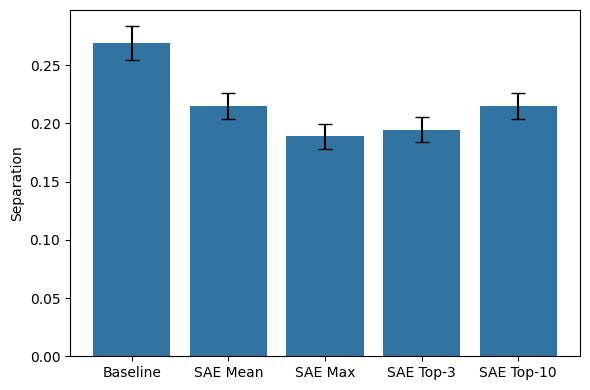

In [19]:
plot_separation([rag_stats, sae_mean_stats, sae_max_stats, sae_top3_stats, sae_top10_stats], ['Baseline', 'SAE Mean', 'SAE Max', 'SAE Top-3', 'SAE Top-10'])

In [20]:
test_method("max")

ValueError: Unknown backend: max. Use 'rag' or 'sae'.

In [22]:
test_method("topk", k=3)

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.43167365 0.06786506
Mean unrelated similarity : 0.2562137 0.059962727
Separation (related - unrelated): 0.17545995

Counts -> related: 18 unrelated: 18


In [23]:
test_method("topk", k=5)

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.4598261 0.06515279
Mean unrelated similarity : 0.29110044 0.061601207
Separation (related - unrelated): 0.16872567

Counts -> related: 18 unrelated: 18


In [24]:
test_method("topk", k=10)

========== RAG SIMILARITY ==========
Mean related similarity   : 0.7980174615796013 0.0447352891689297
Mean unrelated similarity : 0.5882399145760032 0.06277481162354855
Separation (related - unrelated): 0.20977754700359807

========== SAE SIMILARITY ==========
Mean related similarity   : 0.47961175 0.07108512
Mean unrelated similarity : 0.30776542 0.068244085
Separation (related - unrelated): 0.17184633

Counts -> related: 18 unrelated: 18


In [26]:
import numpy as np
from collections import defaultdict

# 1) Run RAG + SAE on all examples and store results
results = []
for ex in examples:
    context = ex["context"]
    pos_q = ex["pos_query"]
    neg_q = ex["neg_query"]

    rag_pos, rag_neg = rag_similarity(context, pos_q, neg_q)
    sae_pos, sae_neg = sae_similarity(context, pos_q, neg_q, 'max')

    results.append({
        "context": context,
        "pos_query": pos_q,
        "neg_query": neg_q,
        "rag_pos": rag_pos,
        "rag_neg": rag_neg,
        "sae_pos": sae_pos,
        "sae_neg": sae_neg,
    })

# 2) Group by context (conversation)
groups = defaultdict(list)
for r in results:
    groups[r["context"]].append(r)

# 3) For each group, compute separation for RAG and SAE
group_summaries = []

for context, group in groups.items():
    rag_pos_vals = [g["rag_pos"] for g in group]
    rag_neg_vals = [g["rag_neg"] for g in group]
    sae_pos_vals = [g["sae_pos"] for g in group]
    sae_neg_vals = [g["sae_neg"] for g in group]

    # Need at least one related and one unrelated to define a separation
    if not rag_pos_vals or not rag_neg_vals or not sae_pos_vals or not sae_neg_vals:
        continue

    rag_sep = np.mean(rag_pos_vals) - np.mean(rag_neg_vals)
    sae_sep = np.mean(sae_pos_vals) - np.mean(sae_neg_vals)

    group_summaries.append({
        "context": context,
        "group": group,
        "rag_sep": rag_sep,
        "sae_sep": sae_sep,
        "delta": sae_sep - rag_sep,  # how much SAE beats RAG (if positive)
    })

# 4) Filter to where SAE outperforms RAG and sort by how much
better_for_sae = [g for g in group_summaries if g["sae_sep"] > g["rag_sep"]]
better_for_sae.sort(key=lambda g: g["delta"], reverse=True)

# 5) Pretty-print the cases where SAE > RAG
for g in better_for_sae:
    print("=" * 80)
    print("Context (conversation):")
    print(g["context"])
    print()
    print(f"RAG separation: {g['rag_sep']:.4f}")
    print(f"SAE separation: {g['sae_sep']:.4f}")
    print(f"SAE - RAG      : {g['delta']:.4f}")

    print("\nRelated (pos_query) and sims:")
    for r in g["group"]:
        print(f"  [RAG={r['rag_pos']:.4f}, SAE={r['sae_pos']:.4f}]  {r['pos_query']}")

    print("\nUnrelated (neg_query) and sims:")
    for r in g["group"]:
        print(f"  [RAG={r['rag_neg']:.4f}, SAE={r['sae_neg']:.4f}]  {r['neg_query']}")
    print()


Context (conversation):
User: I want a sci-fi novel that’s thoughtful but still fun to read. Any ideas?
Assistant: You might enjoy "The Three-Body Problem." It mixes hard science with a very engaging story.

RAG separation: 0.1755
SAE separation: 0.3364
SAE - RAG      : 0.1609

Related (pos_query) and sims:
  [RAG=0.7535, SAE=0.4608]  Which sci-fi book did you recommend that combines hard science with an engaging story?

Unrelated (neg_query) and sims:
  [RAG=0.5780, SAE=0.1244]  Which non-fiction book did you recommend for learning basic investing principles?

Context (conversation):
User: I want a compact camera for street photography, something small but with great image quality. Any suggestions?
Assistant: You might really like the Ricoh GR III. It’s very pocketable and has an excellent 28mm-equivalent lens that’s great for street shots.

RAG separation: 0.1460
SAE separation: 0.2407
SAE - RAG      : 0.0947

Related (pos_query) and sims:
  [RAG=0.7889, SAE=0.4435]  What was the sma

In [30]:
compare(
    "User: I yelled at my sister yesterday and now she won’t talk to me.\n"
    "Assistant: That sounds painful. When something can’t be taken back, the focus becomes repairing trust.\n"
    "User: I wish I could undo it.",
    "How do I deal with a mistake that I can’t take back?"
)

In [13]:
compare("He planted the seed in spring and waited months for anything to happen.",
        "She submitted her PhD application and knew the results would arrive much later.")

RAG similarity: 0.5280847636696077
SAE similarity: 0.15224242210388184


In [14]:
compare("Once the glass shattered, there was no way back.",
        "When she sent the angry email, the relationship changed permanently.")

RAG similarity: 0.4709199426788174


KeyboardInterrupt: 

In [ ]:
compare("He invested everything for a chance at a breakthrough.",
        "She stepped onto the stage knowing the risk was worth the opportunity.")

RAG similarity: 0.5718832471264863
SAE similarity: 0.534549355506897


In [10]:
compare('She closed the window because the cold wind was coming in.',
        'She shut the window to keep the chilly breeze out.')

RAG similarity: 0.9285133402558516
SAE similarity: 0.5873538255691528


In [22]:
compare('He hurried to catch the last train before midnight.',
        'He rushed to board the final train that left just before twelve.')

RAG similarity: 0.9019049688465273
SAE similarity: 0.6499947905540466


In [23]:
compare('The book was so captivating that she finished it in one night.',
        'She read the whole novel in a single evening because it was irresistible.')

RAG similarity: 0.8380246617842546
SAE similarity: 0.6573800444602966


In [24]:
compare('The dog barked loudly at the mail carrier.',
        'The dog made a racket when the postal worker approached.')

RAG similarity: 0.8239608511256304
SAE similarity: 0.589231014251709


In [25]:
compare('The cat slept on the warm radiator.',
        'Quantum computers require extremely low temperatures to operate.')

RAG similarity: 0.5298888996725823
SAE similarity: 0.5248370170593262


In [26]:
compare('The nebula glowed faintly as the telescope adjusted its focus.',
        'I forgot to buy onions for the pasta sauce.')

RAG similarity: 0.34518207932378536
SAE similarity: 0.383361279964447


In [27]:
compare('The café down the street started selling homemade lemonade.',
        'Saturn’s rings are mostly composed of ice particles.')

RAG similarity: 0.31755464184461646
SAE similarity: 0.31813913583755493


In [28]:
compare('My shoes got soaked when it started raining unexpectedly.',
        'The server must be restarted after applying the new kernel patch.')

RAG similarity: 0.3717168859381351
SAE similarity: 0.43883946537971497


In [29]:
compare('What if my child just refuses to take responsibility for their actions? How do I get them to understand the importance of being accountable?',
        'How many days did I spend on camping trips in the United States this year?')

RAG similarity: 0.3164769270993337
SAE similarity: 0.33727002143859863


Aún cuando están relacionados conceptualmente y no semánticamente, RAG es mejor que SAE

In [30]:
compare('If you pack too many tools into a small backpack, something essential will always get left behind.',
        'A neural network with fixed width can’t memorize new patterns without forgetting some of the old ones.')

RAG similarity: 0.4902988564590743
SAE similarity: 0.3685685396194458


In [31]:
compare('A single spark landing in dry grass can turn into a wildfire by nightfall.',
        'One unstable nucleotide in a cell can initiate a cascade of replication errors.')

RAG similarity: 0.540741589430252
SAE similarity: 0.47643065452575684


In [32]:
compare('Watering a plant twice doesn’t make it grow twice as fast.',
        'Doubling your training epochs rarely doubles your model’s accuracy.')

RAG similarity: 0.5917122431442312
SAE similarity: 0.3543633222579956
